In [1]:
import pickle
import pandas as pd
import numpy as np
from mesh_import import mesh
from tqdm.autonotebook import tqdm

E:\LangOn\OntoDeepLex\src\mesh\cns.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
asbc_dir = mesh.get_data_dir()/"asbc"

In [3]:
with (asbc_dir/"asbc5_characters.pkl").open("rb") as fin:
    chfreq = pickle.load(fin)
with (asbc_dir/"asbc5_words.pkl").open("rb") as fin:
    wdfreq = pickle.load(fin)

In [4]:
affix_dir = mesh.get_data_dir() / "affix"
ckip_affix = mesh.affix.CkipAffixes(affix_dir)

In [6]:
from collections import Counter
from itertools import chain

prefix_reweight = {}
suffix_reweight = {}

for wd, wfreq in wdfreq.items():
    if len(wd) < 2: continue
    prefix_reweight[wd[0]] = prefix_reweight.get(wd[0], 0) + 1/wfreq
    suffix_reweight[wd[-1]] = suffix_reweight.get(wd[-1], 0) + 1/wfreq

In [63]:
from math import log
data = []
for ch, cfreq in chfreq.items():
    ch_aswd_freq = wdfreq.get(ch, 0)
    lexicalized = np.log((ch_aswd_freq+1)/cfreq)
    prefix_prod = log(prefix_reweight.get(ch, 0)+1)
    suffix_prod = log(suffix_reweight.get(ch, 0)+1)
    data.append((ch, cfreq, lexicalized, prefix_prod, suffix_prod))
affix_data = pd.DataFrame.from_records(data, 
                                       columns=("character", "ch_freq", 
                                                "lexicalized", "prefix_prod", "suffix_prod"))

In [64]:
for row_idx in tqdm(affix_data.index):
    res = ckip_affix.query(affix_data.loc[row_idx, "character"])
    is_prefix = any(x.affix_type=="prefix" for x in res)
    is_suffix = any(x.affix_type=="suffix" for x in res)
    affix_data.loc[row_idx, "is_prefix"] = is_prefix
    affix_data.loc[row_idx, "is_suffix"] = is_suffix

In [65]:
affix_data.head()

,character,ch_freq,lexicalized,prefix_prod,suffix_prod,is_prefix,is_suffix
0,時,67941,-1.258535,4.268836,4.321109,True,True
1,間,28909,-1.851667,3.493247,4.328211,True,True
2,三,34728,-1.005551,6.994973,5.867328,True,True
3,月,21016,-1.506483,4.296413,4.575039,True,True
4,十,46416,-2.625108,6.073742,5.131008,True,False


Text(0.5, 0.98, 'Scatterplot of prefixes')

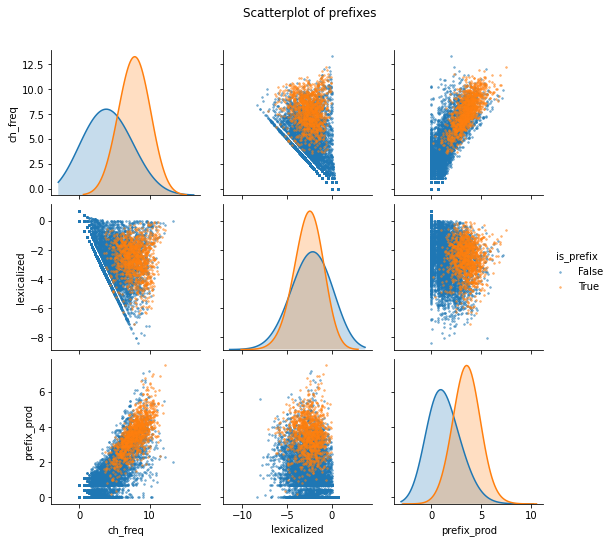

In [66]:
prefix_data = affix_data.loc[:, ["ch_freq", "lexicalized", "prefix_prod", "is_prefix"]]\
                .assign(ch_freq = lambda x: np.log(x.ch_freq))
sns.pairplot(prefix_data, hue="is_prefix", 
             plot_kws=dict(edgecolor=None, s=3, alpha=0.5), 
             diag_kws=dict(bw=1))
plt.subplots_adjust(top=0.9)
plt.gcf().suptitle("Scatterplot of prefixes")

Text(0.5, 0.98, 'Scatterplot of suffixes')

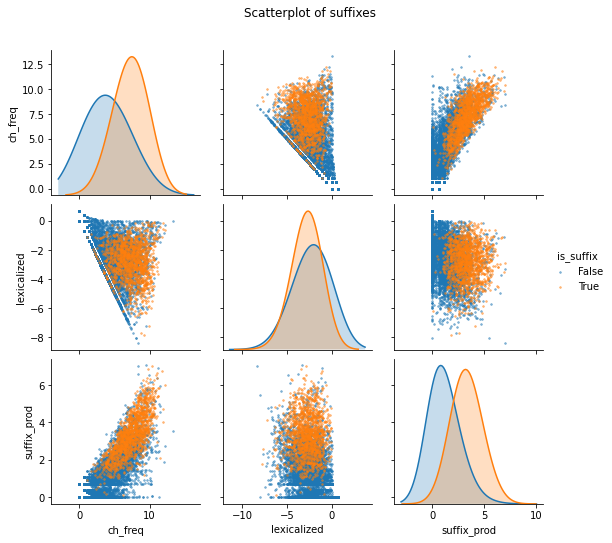

In [67]:
suffix_data = affix_data.loc[:, ["ch_freq", "lexicalized", "suffix_prod", "is_suffix"]]\
                .assign(ch_freq = lambda x: np.log(x.ch_freq))
sns.pairplot(suffix_data, hue="is_suffix", 
             plot_kws=dict(edgecolor=None, s=3, alpha=0.5), 
             diag_kws=dict(bw=1))
plt.subplots_adjust(top=0.9)
plt.gcf().suptitle("Scatterplot of suffixes")

Text(0.5, 0, 'Prefix productivity (reweight)')

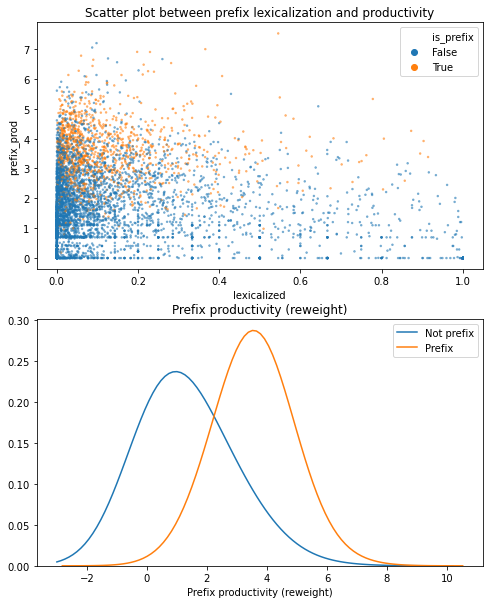

In [43]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(8,10))
sns.scatterplot("lexicalized", "prefix_prod", data=affix_data, hue="is_prefix", 
                edgecolor=None, s=3, alpha=0.5, ax=axes[0])
axes[0].set_title("Scatter plot between prefix lexicalization and productivity")

sns.kdeplot(affix_data.loc[affix_data.is_prefix==False, "prefix_prod"], label="Not prefix", bw=1, ax=axes[1])
sns.kdeplot(affix_data.loc[affix_data.is_prefix==True, "prefix_prod"], label="Prefix", bw=1, ax=axes[1])
plt.title("Prefix productivity (reweight)")
plt.xlabel("Prefix productivity (reweight)")

Text(0.5, 0, 'Suffix productivity (reweight)')

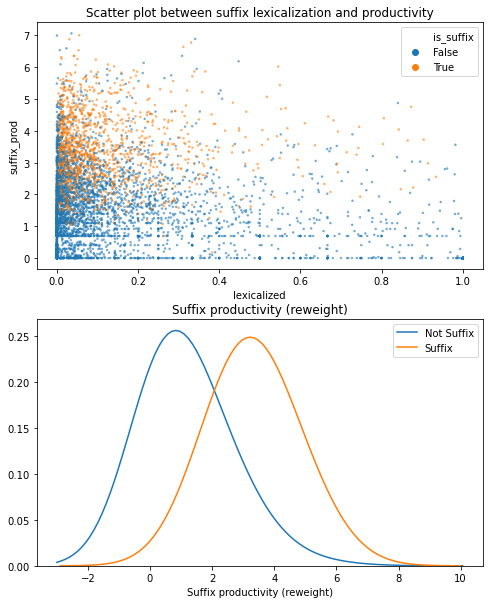

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(8,10))
sns.scatterplot("lexicalized", "suffix_prod", data=affix_data, hue="is_suffix", 
                edgecolor=None, s=3, alpha=0.5, ax=axes[0])
axes[0].set_title("Scatter plot between suffix lexicalization and productivity")
plt.title("Scatter plot between suffix lexicalization and productivity")

sns.kdeplot(affix_data.loc[affix_data.is_suffix==False, "suffix_prod"], label="Not Suffix", bw=1, ax=axes[1])
sns.kdeplot(affix_data.loc[affix_data.is_suffix==True, "suffix_prod"], label="Suffix", bw=1, ax=axes[1])
plt.title("Suffix productivity (reweight)")
plt.xlabel("Suffix productivity (reweight)")

Text(0.5, 0, 'Suffix productivity (reweight)')

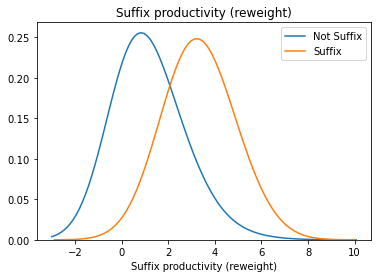

In [34]:
from matplotlib import pyplot as plt
sns.kdeplot(affix_data.loc[affix_data.is_suffix==False, "suffix_prod"], label="Not Suffix", bw=1)
sns.kdeplot(affix_data.loc[affix_data.is_suffix==True, "suffix_prod"], label="Suffix", bw=1)
plt.title("Suffix productivity (reweight)")
plt.xlabel("Suffix productivity (reweight)")